In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import model
import dataset
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [18]:
#Create writer
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/CIFAR10-simple-CNN')

In [19]:
#Set device
#if cuda is available then use cuda, else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
#declare parameters

input_size = 32*32 #image size = 32x32 --flatten 1024
n_classes = 10
n_epoch = 10
batch_size = 100
learning_rate = 0.001

In [21]:
#Make dataset with transform included

#mean = [0.485, 0.456, 0.406]
#std = [0.229, 0.224, 0.225]
mean = (0.5, 0.5, 0.5 )
std = (0.5, 0.5, 0.5)

composed_transform = transforms.Compose([transforms.ToTensor(),
                     transforms.Normalize(mean = mean, std = std)])

train_dataset = dataset.TrainSet(transform = composed_transform)
test_dataset = dataset.TestSet(transform = composed_transform)

#Make dataloader
#Note: DataLoader antomatically transform data from numpy to tensor
#But we still do ToTensor transform to Normalize(normalize require tensor dtype)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle = False)

In [22]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [23]:
#Show some examples to examinate dataloader

examples = iter(test_loader)
example_images, example_labels = examples.next()

#we only need to denormalize images to show on tensorboard, because it accept c h w mode
for i in range(16):
    example_images[i] = example_images[i]/2+0.5

#show the sampled images to tensorboard
#note: make grid images before upload to summarywriter
img_grid = torchvision.utils.make_grid(example_images)
writer.add_image('CIFAR10', img_grid)

In [24]:
model = model.CNN().to(device)

#let's freeze the pretrained layers
#model.features.requires_grad_(False)

#write model graph to tensorboard
writer.add_graph(model, example_images.to(device))

In [25]:
#Define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [26]:
#Make Training Loop

steps = len(train_loader)

print('Start training...')

#declare running parameters for tensorboard
runtime_loss = 0.0
runtime_correct = 0

for epoch in range(n_epoch):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        #Note: Labels are now dtype torch.uint8, should be change to torch.long for CrossEntropyLoss
        labels = labels.type(torch.long)
        labels = labels.to(device)
        #forward pass
        pred_labels = model(images)
        loss = criterion(pred_labels, labels)

        #backward pass
        loss.backward()

        #update gradients
        optimizer.step()
        optimizer.zero_grad()

        #recoard runtime information
        runtime_loss += loss.item()
        _, predicted = torch.max(pred_labels, 1)
        runtime_correct += (predicted == labels).sum().item() 

        #print information in a epoch
        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}/{n_epoch}, step: {(i+1)}/{steps}, loss: {loss.item():.3f}')
            #calculate average percision and loss per step
            writer.add_scalar('training loss', runtime_loss / 100, epoch+1)
            writer.add_scalar('accuracy', runtime_correct / 100, epoch+1)
            #clear runtime information
            runtime_loss = 0.0
            runtime_correct = 0

            
print('Training is completed')

Start training...
epoch: 1/10, step: 100/500, loss: 1.683
epoch: 1/10, step: 200/500, loss: 1.443
epoch: 1/10, step: 300/500, loss: 1.308
epoch: 1/10, step: 400/500, loss: 1.213
epoch: 1/10, step: 500/500, loss: 1.360
epoch: 2/10, step: 100/500, loss: 1.233
epoch: 2/10, step: 200/500, loss: 1.317
epoch: 2/10, step: 300/500, loss: 1.202
epoch: 2/10, step: 400/500, loss: 1.412
epoch: 2/10, step: 500/500, loss: 1.254
epoch: 3/10, step: 100/500, loss: 1.306
epoch: 3/10, step: 200/500, loss: 1.426
epoch: 3/10, step: 300/500, loss: 1.358
epoch: 3/10, step: 400/500, loss: 1.217
epoch: 3/10, step: 500/500, loss: 1.124
epoch: 4/10, step: 100/500, loss: 1.168
epoch: 4/10, step: 200/500, loss: 1.300
epoch: 4/10, step: 300/500, loss: 1.111
epoch: 4/10, step: 400/500, loss: 1.284
epoch: 4/10, step: 500/500, loss: 1.147
epoch: 5/10, step: 100/500, loss: 1.313
epoch: 5/10, step: 200/500, loss: 1.269
epoch: 5/10, step: 300/500, loss: 1.282
epoch: 5/10, step: 400/500, loss: 1.002
epoch: 5/10, step: 500

In [27]:
#Test the model
#Also make the confution matrix
#Also plot PR curve to tensorboard

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    #save predictoins and tragets in linespace to make a confution matrix
    cf_pred = []
    cf_actual = []
    #parameters for tensorboard pr curve
    #pr_prob record the probability predicted
    #pr_pred record whether the prediciton is correct
    pr_prob = []
    pr_pred = []
    for images, labels in test_loader:
        #flatten
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)

        #pr curve require a prediction in probability between[0, 1]. So we must implement with softmax
        #softmax for a batch
        pr_prob_batch = [nn.functional.softmax(outputs, dim=0) for outputs in output]
        pr_pred.append(predicted)
        pr_prob.append(pr_prob_batch)
        
        #transform from tensor to numpy
        predicted = predicted.cpu().numpy()
        cf_pred.extend(predicted)
        labels = labels.cpu().numpy()
        cf_actual.extend(labels)

        n_samples = n_samples + labels.shape[0]
        #Note (predicted == labels) is still a tensor with one element. We need to use item() to get a value
        #then we can compute divition
        n_correct = n_correct + (predicted == labels).sum().item()

acc = n_correct / n_samples
print(f'model accuracy: {acc:.3f}')

model accuracy: 0.601


In [28]:
#create pr curve for tensorboard
#use torch.cat to transfrom list to tensor
pr_prob = torch.cat([torch.stack(batch) for batch in pr_prob]) #[10000, 10]
pr_pred = torch.cat(pr_pred) #[10000]
prob_all = []
pred_all = []
for i in range(10):
        pred_i = pr_pred == i #transfrom a list of labels to a list of boolin
        prob_i = pr_prob[:, i] #given the class predicted probability
        pred_all.append(pred_i)
        prob_all.append(prob_i)
        writer.add_pr_curve(f'class {str(i)} PR curve', pred_i, prob_i, global_step=0)

writer.add_pr_curve('PR curve for all classes', torch.cat(pred_all), torch.cat(prob_all), global_step=0)

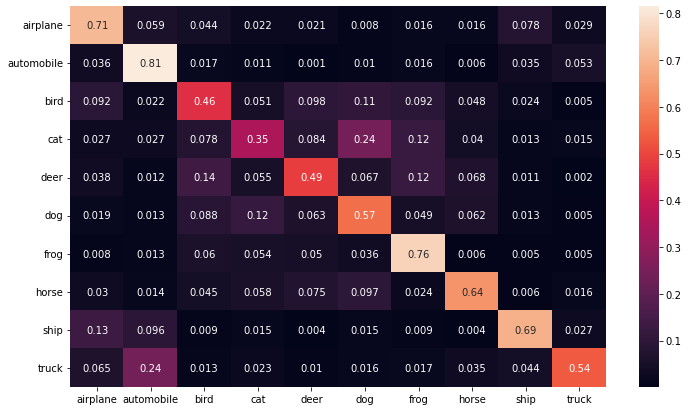

In [29]:
#make confution matrix

#confution_matrix form a 2d array from two seperate 1d array
cf_matrix = confusion_matrix(cf_actual, cf_pred)
#include dataframe showing classes of prediction
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix, axis = 1), index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12, 7))
sn.heatmap(df_cm, annot = True)
plt.show()
cf_img = sn.heatmap(df_cm, annot = True).get_figure()
writer.add_figure('Confution Matrix', cf_img)

In [30]:
#See some predictions of the model

with torch.no_grad():
    examples = iter(test_loader)
    data, actual_labels = examples.next()
    data = data.to(device)
    predicted_labels = model(data)
    _, predicted_labels = torch.max(predicted_labels, 1)

print('predicted labels:\n', predicted_labels.cpu().numpy())
print('actual labels:\n', actual_labels.numpy().squeeze())



predicted labels:
 [3 8 0 8 4 6 1 4 3 1 0 9 5 7 9 6]
actual labels:
 [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8]
